## Image Classification Exercise

Hotdog/not-hotdog classifier using a simple, hand-built CNN.

### Setup and Configuration

In [20]:
# Import necessary Python modules
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from pathlib import Path

print(tf.__version__)
%matplotlib inline

2.8.0


### Data preparation (Kaggle dataset)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [21]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [22]:
# Specify the location of the dataset for the CLI
# dansbecker/hot-dog-not-hot-dog

DATASET_OWNER = "dansbecker"
DATASET_DIR   = "datasets"
DATASET_NAME  = "hot-dog-not-hot-dog"
!mkdir -p "$DATASET_DIR"
!kaggle datasets download "$DATASET_OWNER"/"$DATASET_NAME" -p "$DATASET_DIR"
!unzip -o "$DATASET_DIR"/"$DATASET_NAME".zip -d "$DATASET_DIR"
!rm "$DATASET_DIR"/"$DATASET_NAME".zip

 95%|████████████████████████████████████▏ | 85.0M/89.3M [00:02<00:00, 45.7MB/s]
100%|██████████████████████████████████████| 89.3M/89.3M [00:02<00:00, 40.9MB/s]
Archive:  datasets/hot-dog-not-hot-dog.zip
  inflating: datasets/seefood/test/hot_dog/133012.jpg  
  inflating: datasets/seefood/test/hot_dog/133015.jpg  
  inflating: datasets/seefood/test/hot_dog/133245.jpg  
  inflating: datasets/seefood/test/hot_dog/135628.jpg  
  inflating: datasets/seefood/test/hot_dog/138933.jpg  
  inflating: datasets/seefood/test/hot_dog/138937.jpg  
  inflating: datasets/seefood/test/hot_dog/138969.jpg  
  inflating: datasets/seefood/test/hot_dog/139177.jpg  
  inflating: datasets/seefood/test/hot_dog/142835.jpg  
  inflating: datasets/seefood/test/hot_dog/143012.jpg  
  inflating: datasets/seefood/test/hot_dog/144956.jpg  
  inflating: datasets/seefood/test/hot_dog/146227.jpg  
  inflating: datasets/seefood/test/hot_dog/146834.jpg  
  inflating: datasets/seefood/test/hot_dog/147874.jpg  
  inflating

In [180]:
path_data = Path(DATASET_DIR) / Path("seefood")
path_training_data = Path(DATASET_DIR) / Path("seefood") / Path("train")
path_test_data     = Path(DATASET_DIR) / Path("seefood") / Path("test")

In [127]:
_ = path_test_data / "*"
dirs_test_data = glob.glob(_.as_posix(), recursive=True)

for item in dirs_test_data:
    _ = Path(item) / "*.jpg"
    files_test_data = glob.glob(_.as_posix())
    if len(files_test_data) > 150:
        files_to_move = files_test_data[0:150] 
        
        for src in files_to_move:
            dst = src.replace('test','train')
            # if os.path.exists(dst):
            #     raise ValueError(f"File {dst} exists!")
            os.replace(src, dst)

In [189]:
SEED = 42
COLOR_MODE = "rgb"
batch_size = 8
img_height = 256
img_width  = 256

In [190]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_training_data,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  path_training_data,
  shuffle=True,  
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  path_test_data,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
number_classes = len(class_names)
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 798 files belonging to 2 classes.
Using 639 files for training.
Found 798 files belonging to 2 classes.
Using 159 files for validation.
Found 200 files belonging to 2 classes.
['hot_dog', 'not_hot_dog']


### Data visualization

datasets/seefood/train/hot_dog/307874.jpg
datasets/seefood/train/hot_dog/3494550.jpg
datasets/seefood/train/hot_dog/701763.jpg
datasets/seefood/train/not_hot_dog/126784.jpg
datasets/seefood/train/not_hot_dog/118378.jpg
datasets/seefood/train/not_hot_dog/46401.jpg


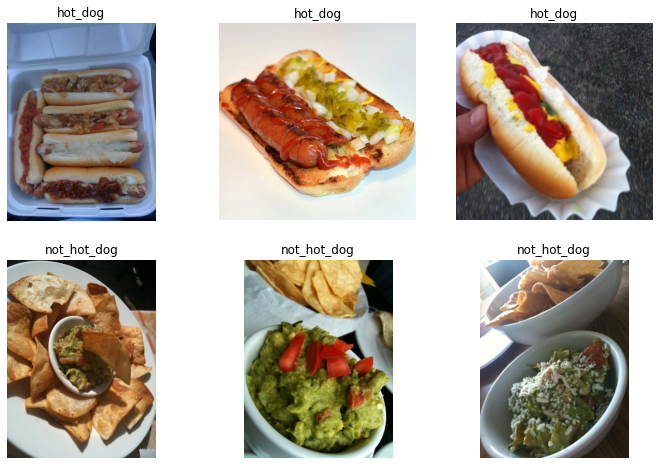

In [191]:
plt.figure(figsize=(12, 8))
counter = 1
for cls in class_names:
    path_images = path_training_data / Path(f"{cls}/*.jpg")
    files_images = glob.glob(path_images.as_posix(),recursive = True)
    for idx in random.sample(range(0, len(files_images)), 3):
        im_cv = cv2.imread(files_images[idx])
        im_cv = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
        print(files_images[idx])
        ax = plt.subplot(number_classes, 3, counter)
        plt.title(cls)
        plt.axis("off")
        plt.imshow(im_cv)
        counter += 1

### Model preparation (TensorFlow)

In [192]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) # pixel values are now in [0,1]

0.0 1.0


#### Prevent overfitting

For prevenging overfitting we augment the data and add a `Dropout` layer to our model.

In [193]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
  ]
)

In [213]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(96, (11, 11), strides=4, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Dense(number_classes) # activation='sigmoid' => logits == False
])

### Model creation

In [214]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                

### Model training

In [222]:
epochs=50
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    # callbacks = [callback]
)

Epoch 1/50
80/80 [==============================] - 38s 472ms/step - loss: 0.7045 - accuracy: 0.5681 - val_loss: 0.6835 - val_accuracy: 0.5660
Epoch 2/50
80/80 [==============================] - 38s 477ms/step - loss: 0.7026 - accuracy: 0.5665 - val_loss: 0.6793 - val_accuracy: 0.5346
Epoch 3/50
80/80 [==============================] - 38s 471ms/step - loss: 0.7080 - accuracy: 0.5587 - val_loss: 0.6862 - val_accuracy: 0.5849
Epoch 4/50
80/80 [==============================] - 37s 463ms/step - loss: 0.7001 - accuracy: 0.5900 - val_loss: 0.7269 - val_accuracy: 0.4843
Epoch 5/50
80/80 [==============================] - 34s 420ms/step - loss: 0.7419 - accuracy: 0.5383 - val_loss: 0.7052 - val_accuracy: 0.5157
Epoch 6/50
80/80 [==============================] - 30s 378ms/step - loss: 0.7270 - accuracy: 0.5571 - val_loss: 0.7222 - val_accuracy: 0.4717
Epoch 7/50
80/80 [==============================] - 30s 380ms/step - loss: 0.7039 - accuracy: 0.5634 - val_loss: 0.6884 - val_accuracy: 0.5723

### Model evaluation (metrics)

In [223]:
model.evaluate(test_ds)

25/25 [==============================] - 2s 83ms/step - loss: 0.7330 - accuracy: 0.6100


[0.7330275774002075, 0.6100000143051147]

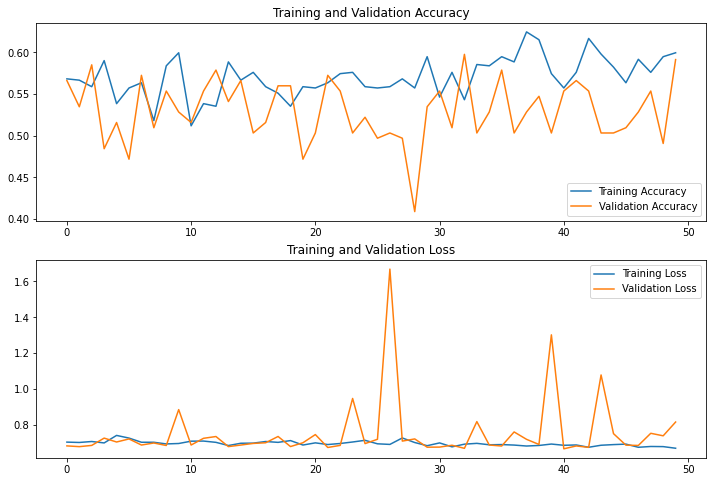

In [224]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model saving (and re-loading)

In [225]:
model.save('model.h5')

In [226]:
new_model = tf.keras.models.load_model('model.h5')
new_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                

datasets/seefood/test/hot_dog/724711.jpg
[hot_dog] | 90.98% confidence
datasets/seefood/test/hot_dog/160523.jpg
[hot_dog] | 64.70% confidence
datasets/seefood/test/hot_dog/193755.jpg
[hot_dog] | 77.94% confidence
datasets/seefood/test/not_hot_dog/33485.jpg
[not_hot_dog] | 52.37% confidence
datasets/seefood/test/not_hot_dog/87125.jpg
[not_hot_dog] | 62.07% confidence
datasets/seefood/test/not_hot_dog/63099.jpg
[not_hot_dog] | 55.18% confidence


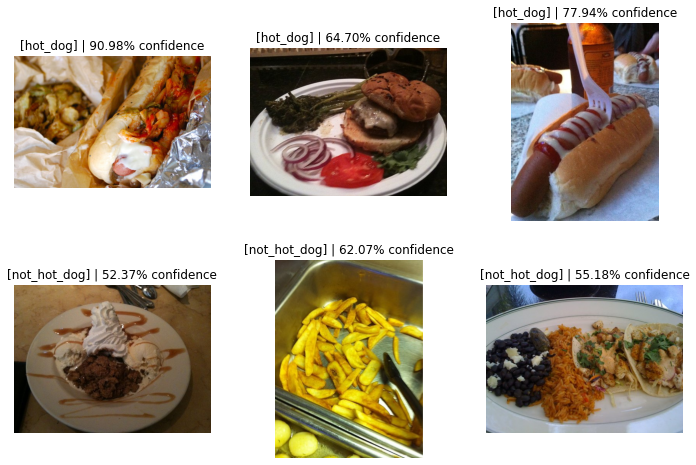

In [230]:
plt.figure(figsize=(12, 8), facecolor='white')
counter = 1
for cls in class_names:
    path_images = path_test_data / Path(f"{cls}/*.jpg")
    files_images = glob.glob(path_images.as_posix(),recursive = True)
    for idx in random.sample(range(0, len(files_images)), 3):
        img = cv2.imread(files_images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = tf.image.resize(img, [256, 256])
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        # predictions = model.predict(img_array) # sanity check with model in memory
        predictions = new_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        ax = plt.subplot(number_classes, 3, counter)
        pred_str = "[{}] | {:.2f}% confidence".format(class_names[np.argmax(score)], 100 * np.max(score))
        plt.title(pred_str)
        plt.axis("off")
        plt.imshow(img)

        print(files_images[idx])
        print(pred_str)

        counter += 1